In [1]:
### IMPORT 

# !pip install npTDMS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from nptdms import TdmsFile
from scipy.signal import find_peaks

import os

In [2]:
### SELECT THE FILE

# folder = 'C:/Users/huynh/INT/karthala/data/2022_12_02P8_jedi_JC_best/points/points0008_best'
# file = 'points0008_pmt1.tdms'

### For Alberto's data
# folder = 'C:/Users/huynh/INT/karthala/data/23_07_10_alberto/points/points0005_2023_07_10'
# file = '2023_07_10_points0005_pmt1.tdms'

### For Nicolas data
folder = 'C:/Users/huynh/INT/karthala/data/GEVI_trace_Force1a/points0012'
file = 'points0012_pmt1.tdms'

In [3]:
### VIEW RECORDING PARAMETERS

path = os.path.join(folder, file)
tdms_file = TdmsFile.read(path)

parameter_group = tdms_file['parameter']
print("parameter_group: ", parameter_group)

name_channel = parameter_group['parameter']
print("name_channel: ", name_channel)

num_channel = parameter_group['value']
print("num_channel: ", num_channel)

name = name_channel[:]
print("name: ", name)

num = num_channel[:]
print("num: ", num)

parameter = np.vstack((name, num))
print("parameter: ", parameter) 

numpoint = int(num[8]) # 8 is the array representing the number of points
print("numpoint: ", numpoint)

### NOTES:
# timing: µs for one ROI, including delay of 10µs to move to next ROI

parameter_group:  <TdmsGroup with path /'parameter'>
name_channel:  <TdmsChannel with path /'parameter'/'parameter'>
num_channel:  <TdmsChannel with path /'parameter'/'value'>
name:  ['mode' 'aom power (%)' 'aom atténuation' 'wavelength' 'timing' 'trigger'
 'pattern' 'z actual point' 'nbr of point' 'number of sample'
 'number of trigger' 'active' 'ulove selector' 'x size' 'y size' '2043'
 '2155' '2015' '2051' '2115']
num:  ['continuous' '42.150' '2.000' '920.000' '70' 'false' 'true' '78' '5'
 '5000' '1' 'true' '2' '15' '5' '2552' '2580' '2600' '2656' '2640']
parameter:  [['mode' 'aom power (%)' 'aom atténuation' 'wavelength' 'timing'
  'trigger' 'pattern' 'z actual point' 'nbr of point' 'number of sample'
  'number of trigger' 'active' 'ulove selector' 'x size' 'y size' '2043'
  '2155' '2015' '2051' '2115']
 ['continuous' '42.150' '2.000' '920.000' '70' 'false' 'true' '78' '5'
  '5000' '1' 'true' '2' '15' '5' '2552' '2580' '2600' '2656' '2640']]
numpoint:  5


In [4]:
### EXTRACT SIGNAL FROM TDMS FILE

time = tdms_file['PMT1']['POI time'].data/1000

roi = []
# Loading all data points
for n in range(numpoint):
    roi.append(tdms_file['PMT1']['POI ' + str(n) + ' '].data)

roi = np.array(roi, dtype=float)  # Convert roi to double
secperframe = time[1]
framespersec = 1/secperframe
print("secperframe: ", secperframe)

print("framespersec: ", 1 / secperframe, 'Hz')

# timemax = f"{max(time)} seconds"
timemax = max(time)
print("duration (s): ", timemax)

print('original roi count: ', roi.shape[0])
print('original roi length: ', roi.shape[1])
print('original roi signal: ', roi)

secperframe:  0.00035000000000000005
framespersec:  2857.142857142857 Hz
duration (s):  324.1507500092567
original roi count:  5
original roi length:  926146
original roi signal:  [[21. 23. 29. ... 28. 26. 21.]
 [33. 27. 29. ... 34. 39. 41.]
 [28. 36. 38. ... 30. 27. 33.]
 [44. 48. 38. ... 60. 44. 38.]
 [38. 48. 44. ... 30. 47. 34.]]


In [5]:
### COMBINE ROIS FROM THE SAME CELL

roi_combined = []

# roi[0] = roi[0] + roi[1] # For JC.  this is an element-wise addition; this doubles the amplitude of the signal
# roi_combined = roi[0] + roi[1] # For alberto.  
roi_combined = roi[0] + roi[1] + roi[2] + roi[3] + roi[4] # For Nicolais.  NOTE:  0 and 1 have worse SNR, but still better all 5 than removing 0 and 1.

In [ ]:
### PLOT ROIS (SEPARATELY AND COMBINED)

fig = go.Figure()

### Loop through each array and add it as a separate trace
for i in range(numpoint):
    array = roi[i]
    fig.add_trace(go.Scatter(y=array, mode='lines', name=f'Array {i+1}'))

fig.add_trace(go.Scatter(y=roi_combined, mode='lines', name='roi_combined'))
# fig.add_trace(go.Scatter(y=roi_combined_234, mode='lines', name='roi_combined'))
# fig.add_trace(go.Scatter(y=roi_combined_01234, mode='lines', name='roi_combined'))


fig.update_layout(
    title="ROIS separated and combined",
    xaxis_title="Time (frame)",
    yaxis_title="Amplitude"
)

# Show the plot
fig.show()

In [13]:
### REMOVE INDIVIDUAL ROIs (use just combined ROI going forward)
roi = []

roi = roi_combined.copy() # For Force1a, not necessary to negate
# roi = -roi_combined.copy() # For Jedi, negate 

In [25]:
### IMPORTANT FUNCTIONS 

from scipy import signal
from scipy.signal import savgol_filter
import numpy as np
from scipy.signal import butter, filtfilt


def median_normalization(traces):
    median_values = np.median(traces, axis=1, keepdims=True)
    return traces / median_values

def detrend_polyfit(traces, deg=15):
    n_frames = len(traces)
    time_vector = np.arange(n_frames)
    p0 = np.polyfit(time_vector, traces.T, deg)
    baseline = np.polyval(p0.T, time_vector)
    return traces - baseline, baseline

def zscore_normalization(traces):
    mean_traces = np.mean(traces, keepdims=True)
    std_traces = np.std(traces, keepdims=True)
    return (traces - mean_traces) / std_traces

def butter_lowpass_filter(data, cutoff_frequency, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    lowpass_filtered_data = filtfilt(b, a, data)
    return lowpass_filtered_data

def baseline_removal_butterworth(signal, cutoff_frequency, sampling_rate, order=4):
    # Apply a low-pass Butterworth filter to estimate baseline
    baseline_estimate = butter_lowpass_filter(signal, cutoff_frequency, sampling_rate, order)
    baseline_removed_signal = signal - baseline_estimate    
    return baseline_removed_signal

def sec_to_frame (time_in_sec):
    return int(time_in_sec*framespersec)

def calculate_moving_average(trace, window_sec=0.5):
    # Calculate the moving average
    window_frames = int(window_sec * framespersec)
    moving_avg = np.convolve(trace, np.ones(window_frames)/window_frames, mode='same')
    return moving_avg

def find_peaks_zscore(trace, window_sec=0.5, z_threshold=4, distance=100):
    # Calculate the standard deviation
    moving_std = np.std(trace)
    moving_avg = calculate_moving_average(trace,window_sec)
    # Find peaks based on 4 standard deviations over the moving average
    threshold = z_threshold * moving_std
    peaks, _ = find_peaks(trace, height=moving_avg + threshold, distance=distance)
    # peaks = [i for i in range(len(trace)) if trace[i] > moving_avg[i] + threshold]
    return peaks

In [ ]:
### APPLY BUTTERWORTH BANDPASS FILTER 
### Here I plot a range to cutoff frequencies.  
### Tip:  use the lowest cutoff possible (.2 or .5) that straightens baselines while preserving the shape of spikes.
### Note:  Villette used 20, not sure why so high

signal = roi.copy()

### Butterworth parameters
order = 1 # lower order = less complex curvature but more authentic
cutoff_frequency = .2  # .2 best so far.  

roi_butterfilt = baseline_removal_butterworth(signal, cutoff_frequency, sampling_rate=framespersec)

### PLOT 
fig = go.Figure()

x_values = [i * secperframe for i in range(len(roi))] # Convert x axis from frames to seconds

# Compare different cut-off frequencies, select the lowest one that removes drift
fig.add_trace(go.Scatter(x=x_values, y=roi, mode='lines', name='0'))
fig.add_trace(go.Scatter(x=x_values, y=baseline_removal_butterworth(signal, cutoff_frequency = .2, sampling_rate=framespersec), mode='lines', name='.2'))
fig.add_trace(go.Scatter(x=x_values, y=baseline_removal_butterworth(signal, cutoff_frequency = .5, sampling_rate=framespersec), mode='lines', name='.5'))
fig.add_trace(go.Scatter(x=x_values, y=baseline_removal_butterworth(signal, cutoff_frequency = 1, sampling_rate=framespersec), mode='lines', name='1'))
# fig.add_trace(go.Scatter(y=baseline_removal_butterworth(signal, cutoff_frequency = 20, sampling_rate=framespersec), mode='lines', name='20')) # suggestion from Villette paper

fig.update_layout(
    title='Comparing Butterworth cutoff frequencies',
    xaxis_title='Time (sec)',
    yaxis_title='Amplitude'
)

# Show the plot
fig.show()

In [ ]:
### COMPARING DETRENDING METHODS:  POLY FIT vs BUTTERWORTH FILTER.  
### CONCLUSION:  SIMILAR, so go with Villette method (Butterworth).  

# import plotly.graph_objects as go

# roi_detrend = detrend_polyfit(roi.copy(),deg = 15)
# roi_detrend_zscore = zscore_normalization(roi_detrend[0].copy())

# x_values = [i * secperframe for i in range(len(roi))]

# fig = go.Figure()

# # fig.add_trace(go.Scatter(x=x_values, y=roi, mode='lines', name='original'))
# # fig.add_trace(go.Scatter(x=x_values, y=roi_detrend[1], mode='lines', name='detrend line'))
# # fig.add_trace(go.Scatter(x=x_values, y=roi_detrend[0], mode='lines', name='detrend'))
# fig.add_trace(go.Scatter(x=x_values, y=zscore_normalization(roi_detrend[0].copy()), mode='lines', name='detrend + zscore'))
# fig.add_trace(go.Scatter(x=x_values, y=zscore_normalization(roi_butterfilt.copy()), mode='lines', name='butterfilt + zscore'))


# fig.update_layout(
#     xaxis_title='Time (sec)',
#     yaxis_title='Amplitude'
# )
# fig.show()


# roi_detrend = roi_detrend[0] # remove traces to make it easier to work with

In [ ]:
### APPLY ZSCORE NORMALIZATION 

signal = roi_butterfilt.copy()
roi_butterfilt_zscore = zscore_normalization(signal.copy())

### PLOT 
x_values = [i * secperframe for i in range(len(roi))] # Convert x axis from frames to seconds

fig = go.Figure()

fig.add_trace(go.Scatter(x=x_values, y=roi, mode='lines', name='original'))
fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt, mode='lines', name='butterfilt'))
fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt_zscore, mode='lines', name='butterfilt + zscore'))

fig.update_layout(
    title='Adding zscore normalization (on top of Butterworth filter)',
    xaxis_title='Time (sec)',
    yaxis_title='Amplitude'
)
fig.show()

In [ ]:
# ### COMPARE NORMALIZATION METHODS:  GAUSSIAN (and kernel sizes) VS SAVITZ GOLAY
# ### Conclusion:  they look similar, so let's go with Villette method (Gaussian)    
# ### However, kernel of 0.2 ms (from paper) has been raised (per Phan's opinion) 

# from scipy.ndimage import gaussian_filter1d

# signal = roi_butterfilt_zscore.copy()
# framespersec
# kernel_sec = 0.005 # raised to 0.005 (sigma = 10.6) from 0.0002 (sigma = .4) because it looks better 
# sigma = kernel_sec * framespersec / (2 * (2 * np.log(2))**0.5)
# roi_butterfilt_zscore_gaussian = gaussian_filter1d(signal.copy(), sigma = 10)

# roi_butterfilt_zscore_savgol = savgol_filter(signal.copy(), window_length = 25, polyorder = 6)

# # Convert x axis from frames to seconds
# x_values = [i * secperframe for i in range(len(roi))]

# fig = go.Figure()

# # fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt_zscore.copy(), mode='lines', name='roi_butterfilt_zscore'))
# fig.add_trace(go.Scatter(x=x_values, y=gaussian_filter1d(signal.copy(), sigma = .5), mode='lines', name='.5'))
# fig.add_trace(go.Scatter(x=x_values, y=gaussian_filter1d(signal.copy(), sigma = 2), mode='lines', name='2'))
# fig.add_trace(go.Scatter(x=x_values, y=gaussian_filter1d(signal.copy(), sigma = 5), mode='lines', name='5'))
# fig.add_trace(go.Scatter(x=x_values, y=gaussian_filter1d(signal.copy(), sigma = 10), mode='lines', name='10'))
# fig.add_trace(go.Scatter(x=x_values, y=gaussian_filter1d(signal.copy(), sigma = 20), mode='lines', name='5'))

# fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt_zscore_savgol, mode='lines', name='roi_butterfilt_zscore_savgol'))


# fig.update_layout(
#     title='Comparing Gaussian to SavitzGolay smoothing',
#     xaxis_title='Time (sec)',
#     yaxis_title='Amplitude'
# )
# fig.show()

In [ ]:
### APPLY GAUSSIAN SMOOTHING
### ONLY apply if it helps the SNR (For example, not useful for Nicolas' data)
### Villette smoothed with kernel = .5 ms

from scipy.ndimage import gaussian_filter1d

signal = roi_butterfilt_zscore.copy()
kernel_sec = 0.0005 # Villette paper used 0.0002 (sigma = .4), but I increased to 0.005 (sigma = 10.6) for easier analysis
sigma = kernel_sec * framespersec / (2 * (2 * np.log(2))**0.5)

roi_butterfilt_zscore_gaussian = gaussian_filter1d(signal.copy(), sigma)
roi_butterfilt_zscore_gaussian_0002 = gaussian_filter1d(signal.copy(), sigma=0.42466) # 0.42466 is based on kernel_sec = .0002, from Villette paper

x_values = [i * secperframe for i in range(len(roi))]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x_values, y=signal.copy(), mode='lines', name='Before smoothing'))
fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt_zscore_gaussian, mode='lines', name='Gaussian Smoothing'))
fig.add_trace(go.Scatter(x=x_values, y=roi_butterfilt_zscore_gaussian_0002, mode='lines', name='Gaussian Smoothing (.0002s)'))

fig.update_layout(
    title='Adding Gaussian smoothing to butterfilter and zscore',
    xaxis_title='Time (sec)',
    yaxis_title='Amplitude'
)
fig.show()

In [23]:
### PLOT THE SIGNAL FREQUENCY SPECTRUM
### Conclusion:  not helpful

# signal = roi_butterfilt_zscore_gaussian.copy()
# signal = roi_butterfilt.copy()

# fft_result = np.fft.fft(signal.copy())
# freqs = np.fft.fftfreq(len(fft_result), 1 / framespersec)  # Frequency bins

# # Plot the magnitude spectrum
# plt.figure(figsize=(8, 6))
# plt.plot(freqs[:len(freqs)//2], np.abs(fft_result)[:len(freqs)//2])  # Plot only positive frequencies
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')
# plt.title('Magnitude Spectrum of the Signal')
# plt.grid(True)
# plt.yscale('log')  # Set y-axis to logarithmic scale

# plt.show()

In [ ]:
### FIND PEAKS 


# signal = roi_butterfilt_zscore_gaussian.copy()
signal = roi_butterfilt.copy() # For Nikolai, zscore and gaussian seemed unnecessary

z_threshold = 5 # 5 for Alberto, 4 for JC.  Villette uses 4
window_sec=0.5
peaks_found = find_peaks_zscore(signal.copy(),window_sec,z_threshold) 

print("peaks count: ", len(peaks_found))
print("spikes / sec: ", len(peaks_found)/timemax)

# Create Plotly figure
fig = go.Figure()

x_values = [i * secperframe for i in range(len(roi))] # Convert x axis from frames to seconds

# fig.add_trace(go.Scatter(x=x_values, y=roi, mode='lines', name='roi'))
fig.add_trace(go.Scatter(x=x_values, y=signal, mode='lines', name='roi_butterfilt_zscore_gaussian'))
fig.add_trace(go.Scatter(x=x_values, y=calculate_moving_average(signal), mode='lines', name='moving_avg'))


### IDENTIFY an isolated spike for MLspike autocalibration [didn't work]
iso_start_sec = 160  # Example value, you should specify your desired start x value
iso_end_sec = 170   # Example value, you should specify your desired end y value
print("iso_start_frame: ", sec_to_frame(iso_start_sec))
print("iso_end_frame: ", sec_to_frame(iso_end_sec))
# Create a trace for the highlighted segment
iso_x = x_values[sec_to_frame(iso_start_sec):sec_to_frame(iso_end_sec)]
iso_y = signal[sec_to_frame(iso_start_sec):sec_to_frame(iso_end_sec)]
fig.add_trace(go.Scatter(x=iso_x, y=iso_y, mode='lines', name='isolated spike'))

# Mark the peaks
peaks_x = [x_values[i] for i in peaks_found]
peaks_y = [signal[i] for i in peaks_found]
fig.add_trace(go.Scatter(x=peaks_x, y=peaks_y, mode='markers', name='Peaks', marker=dict(color='red', size=8)))

print("avg amplitude: ", np.average(peaks_y)) 
print("noise level (std / A): ", np.std(signal)/np.average(peaks_y)) # slightly over overestimated given that amplitudes were not removed from calculation

# Add titles and labels
fig.update_layout(
    title="Detect peaks in spikes",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude"
)
fig.show()

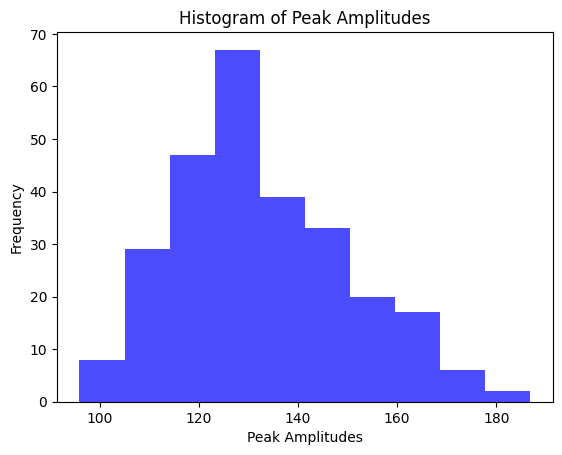

In [27]:
### HISTOGRAM OF AMPLITUDES

peak_amplitudes = [signal[i] for i in peaks_found]

# Number of bins for the histogram
num_bins = 10

# Create histogram
plt.hist(peak_amplitudes, bins=num_bins, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Peak Amplitudes')
plt.ylabel('Frequency')
plt.title('Histogram of Peak Amplitudes')

# Show the plot
plt.show()

n_peaks:  268
n_selected_peaks:  14


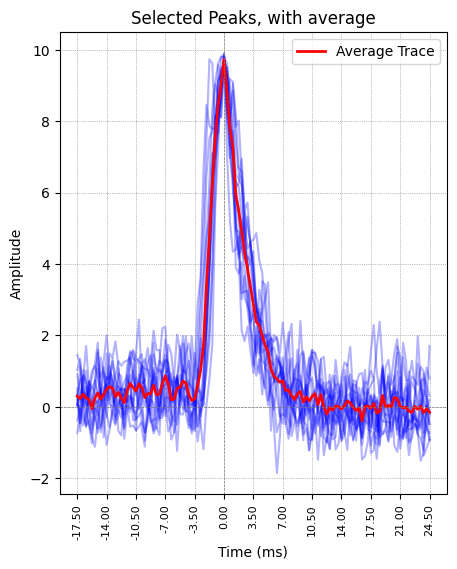

In [28]:
### PLOT AVERAGE SPIKE 

signal = roi_butterfilt_zscore_gaussian.copy()
# signal = roi_butterfilt.copy() # For nikolai, removed zscore and gaussian 

# Parameters for find_peaks function
z_threshold = 5
window_sec = 0.5
peaks = find_peaks_zscore(signal.copy(), window_sec, z_threshold) 

x = np.arange(len(signal))
y = signal # here, we could also get spikes from the original signal (before preprocessed)
peak_amplitudes = y[peaks]

# Instead of averaging all spikes, I seletected just the "best" :  
threshold_low = np.percentile(peak_amplitudes, 85) 
threshold_high = np.percentile(peak_amplitudes, 90)
selected_peaks = [peaks[i] for i in range(len(peaks)) if threshold_low <= peak_amplitudes[i] <= threshold_high]
print("n_peaks: ", len(peaks))
print('n_selected_peaks: ', len(selected_peaks))

# Define the window size around
segment_length_before = 50 # 150 for Jedi, 50 for Force1a
segment_length_after = 70 # 250 for Jedi, 70 for Force1a

# Create segments around each selected peak
segments = []
for peak in selected_peaks:
    # Ensure the peak is not near the edges of the signal
    if peak - segment_length_before >= 0 and peak + segment_length_after < len(signal):
        # Extract segment around the peak
        segment = signal[peak - segment_length_before : peak + segment_length_after + 1]
        segments.append(segment)

# Calculate the average trace 
average_trace = np.mean(segments, axis=0)

# Convert x-axis ticks to represent secperframe
x_ticks_sec = np.arange(-segment_length_before * secperframe*1000, (segment_length_after + 1) * secperframe*1000, step=secperframe*1000)
x_ticks_labels = [f'{tick:.2f}' for tick in x_ticks_sec]

# Visualize the segments and the average trace
plt.figure(figsize=(5, 6))
for segment in segments:
    plt.plot(segment, color='blue', alpha=0.3)  # Individual segments in blue with transparency
plt.plot(average_trace, color='red', linewidth=2, label='Average Trace')  # Average trace in red
plt.axvline(x=segment_length_before, color='gray', linestyle='--', linewidth=0.5)  # Vertical line at time zero
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal line at amplitude zero
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Selected Peaks, with average')

# plt.xticks(ticks=np.arange(0, len(average_trace), step=50), labels=x_ticks_labels[::50])  # for Jedi
plt.xticks(ticks=np.arange(0, len(average_trace), step=10), labels=x_ticks_labels[::10], fontsize=8, rotation='vertical')  # for Force1a

plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add gridlines for better readability
plt.show()


In [ ]:
### PLOT AVERAGE SPIKE, VERSION 2
### Here, the plot is updated so that the amplitude is based on a local baseline rather than simply 0.  
###  But difference seems negligible  

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

signal = roi_butterfilt_zscore_gaussian.copy()

z_threshold = 4
window_sec = 0.5
peaks = find_peaks_zscore(signal.copy(), window_sec, z_threshold) 

x = np.arange(len(signal))
y = roi_butterfilt_zscore_gaussian  # Here we want to apply the peaks from roi_butterfilt_zscore_gaussian to the original signal
peak_amplitudes = []

# Length of segments before and after the peak
segment_length_before = 150
segment_length_after = 250

# The amplitude is based on a local baseline 
# local baseline = average of a segment (length = baseline window) of the signal preceding (distance = tau_rise) the peak
tau_rise_sec = .01 # visual estimate from plot 
tau_rise = int(tau_rise_sec * framespersec)
baseline_window_sec = .03 # villette used 0.0003, which seems very short. 
baseline_window = int(baseline_window_sec * framespersec)

# Create segments around each selected peak
for peak in peaks:
    # Ensure the peak is not near the edges of the signal
    if peak - baseline_window >= 0 and peak + segment_length_after < len(signal):
        # Extract segment before the peak
        segment_before_peak = signal[peak - baseline_window - tau_rise : peak - tau_rise]
        
        # Calculate the average of the segment before the peak
        average_before_peak = np.mean(segment_before_peak)
        
        # Calculate the peak amplitude as y[peak] - average_before_peak
        peak_amplitude = y[peak] - average_before_peak
        peak_amplitudes.append(peak_amplitude)

# Determine the percent thresholds for peaks
threshold_low = np.percentile(peak_amplitudes, 80)
threshold_high = np.percentile(peak_amplitudes, 90)

# Filter peaks within the specified range
selected_peaks = [peaks[i] for i in range(len(peaks)) if threshold_low <= peak_amplitudes[i] <= threshold_high]
print("n_peaks: ", len(peaks))
print('n_selected_peaks: ', len(selected_peaks))

# List to store segments
segments = []

# Create segments around each selected peak
for peak in selected_peaks:
    # Ensure the peak is not near the edges of the signal
    if peak - segment_length_before >= 0 and peak + segment_length_after < len(signal):
        # Extract segment around the peak
        segment = signal[peak - segment_length_before : peak + segment_length_after + 1]
        segments.append(segment)

# Calculate the average trace from the segments
average_trace = np.mean(segments, axis=0)

# Convert x-axis ticks to represent secperframe
x_ticks_sec = np.arange(-segment_length_before * secperframe, (segment_length_after + 1) * secperframe, step=secperframe)
x_ticks_labels = [f'{tick:.2f}' for tick in x_ticks_sec]

# Visualize the segments and the average trace
plt.figure(figsize=(5, 6))
for segment in segments:
    plt.plot(segment, color='blue', alpha=0.3)  # Individual segments in blue with transparency
plt.plot(average_trace, color='red', linewidth=2, label='Average Trace')  # Average trace in red
plt.axvline(x=segment_length_before, color='gray', linestyle='--', linewidth=0.5)  # Vertical line at time zero
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal line at amplitude zero
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Selected Peaks FROM ROI, with local baseline')
plt.xticks(ticks=np.arange(0, len(average_trace), step=50), labels=x_ticks_labels[::50])  # Adjust ticks and labels
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5, color='gray')  # Add gridlines for better readability
plt.show()


In [ ]:
### EXPORT SIGNAL FOR MLSPIKE ANALYSIS IN MATLAB

import scipy.io

# mls_bfilt_zscr_gaus = roi_butterfilt_zscore_gaussian.reshape((1, -1))
# # np.save("C:/Users/huynh/INT/karthala/cascade/dFFv.npy",dFFv)
# scipy.io.savemat("C:/Users/huynh/INT/karthala/mls_bfilt_zscr_gaus.mat", {'mls_bfilt_zscr_gaus': mls_bfilt_zscr_gaus})

# alberto_mls_bfilt_zscr_gaus = roi_butterfilt_zscore_gaussian.reshape((1, -1))
# scipy.io.savemat("C:/Users/huynh/INT/karthala/alberto_mls_bfilt_zscr_gaus.mat", {'alberto_mls_bfilt_zscr_gaus': alberto_mls_bfilt_zscr_gaus})

nikolai_mlspk_bfilt_zscr_gaus = roi_butterfilt_zscore_gaussian.reshape((1, -1))
scipy.io.savemat("C:/Users/huynh/INT/karthala/nikolai_mlspk_bfilt_zscr_gaus.mat", {'nikolai_mlspk_bfilt_zscr_gaus': nikolai_mlspk_bfilt_zscr_gaus})

nikolai_mlspk_bfilt = roi_butterfilt.reshape((1, -1))
scipy.io.savemat("C:/Users/huynh/INT/karthala/nikolai_mlspk_bfilt.mat", {'nikolai_mlspk_bfilt': nikolai_mlspk_bfilt})

np.save('C:/Users/huynh/INT/karthala/nikolai_s2p_bfilt_zscr_gaus.npy', roi_butterfilt_zscore_gaussian)